# 现代循环神经网络---（GRU）

# GRU是一个稍微简化的LSTM 计算速度更快

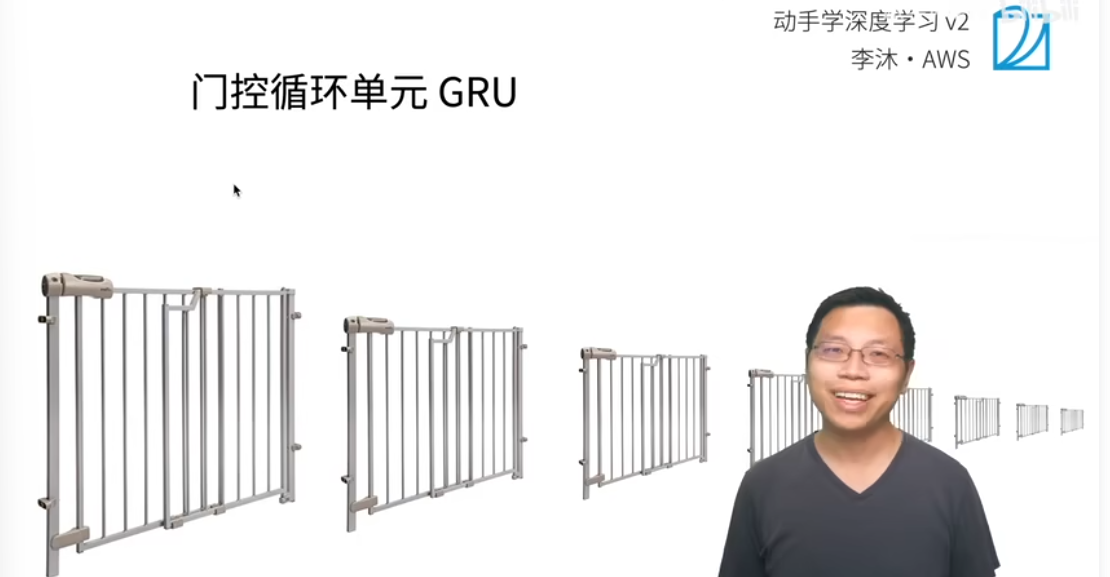

# 去关注那块更加重要 那块更加不重要

# 更新门（关注）和重置门（遗忘）

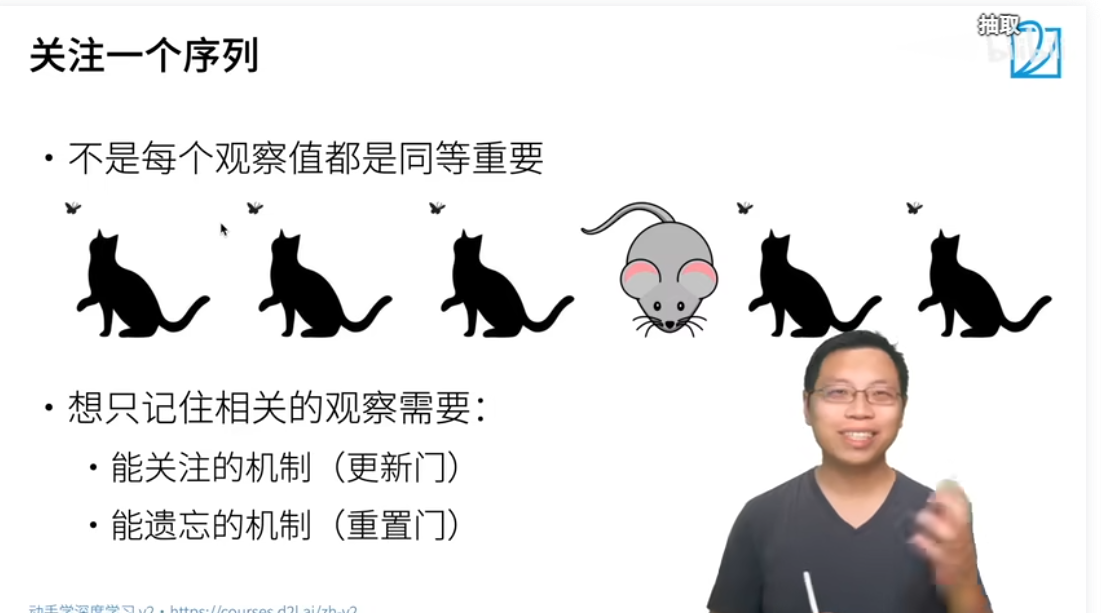

# 门（在之前的基础上多了两个权重计算）

# 等价于两个全连接层的计算
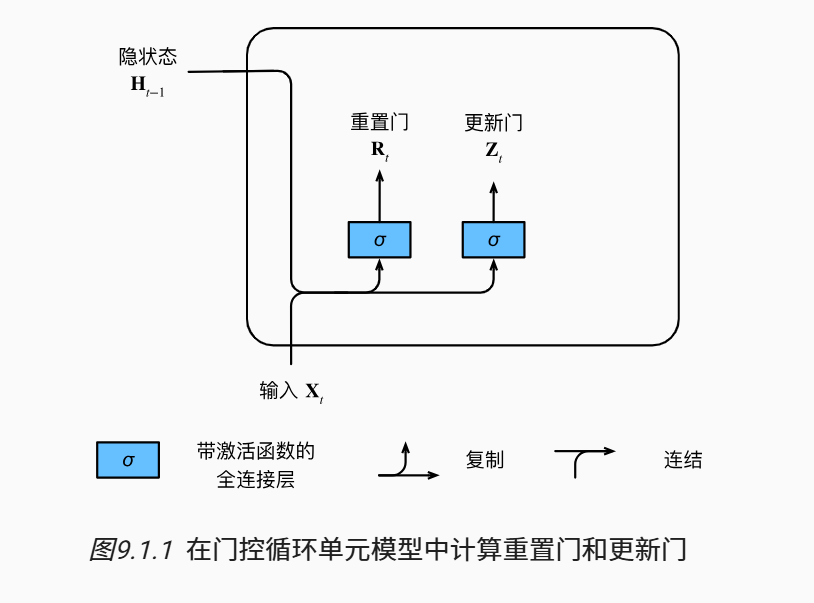


# 候选隐藏状态

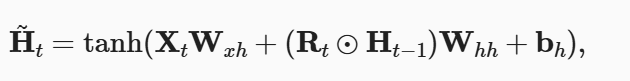

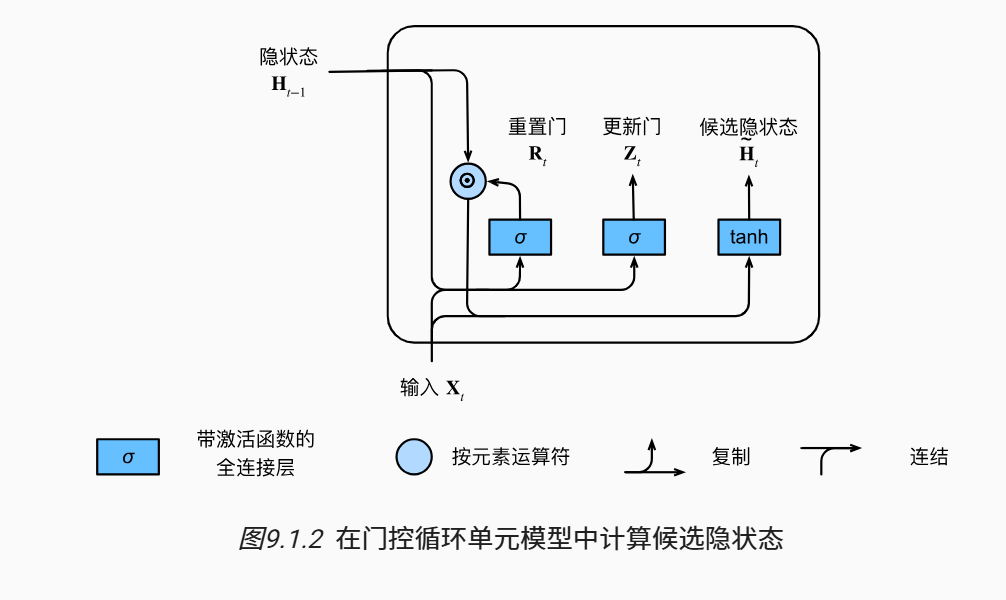



# 隐状态
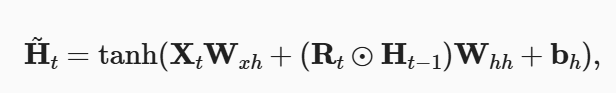

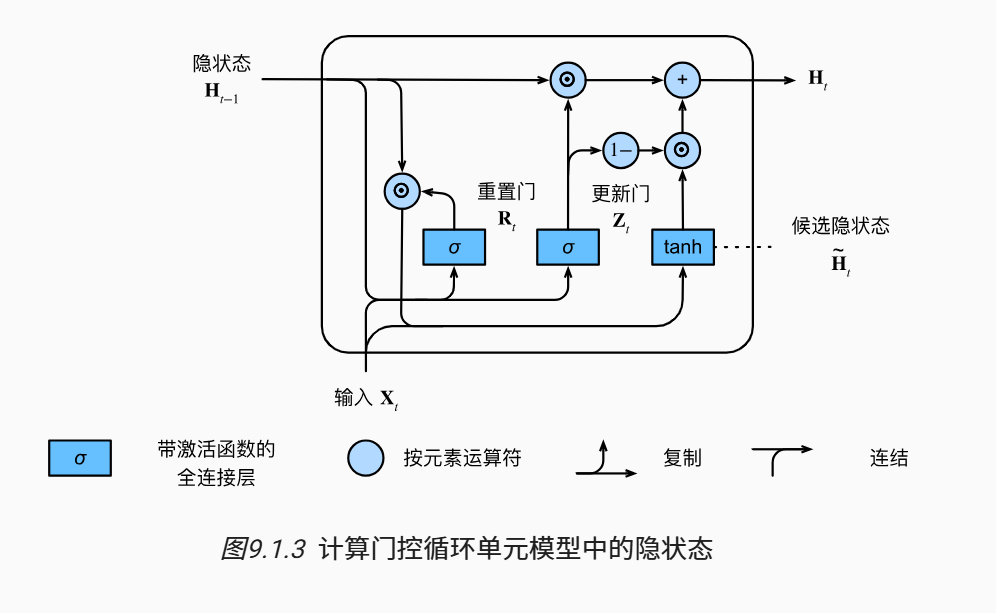

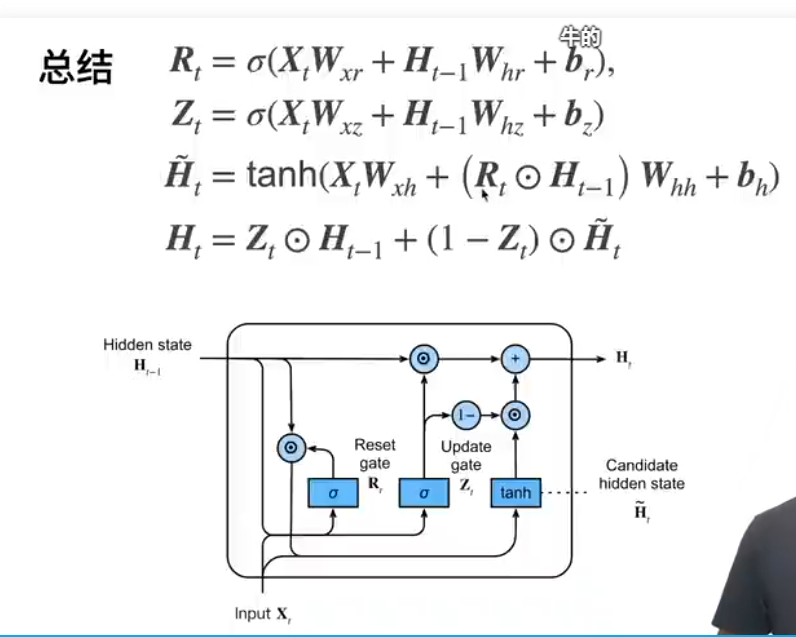

In [1]:
# 门控循环单元（GRU）的实现

import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [6]:
# 初始化模型参数

def get_params(vocab_size, num_hiddens, device):
    """
    初始化 GRU 的参数。

    参数:
    - vocab_size: 词汇表的大小，输入和输出的特征数量。
    - num_hiddens: 隐藏层的神经元数量。
    - device: 张量存储的设备（CPU 或 GPU）。

    返回:
    - params: 包含 GRU 所有参数的列表。
    """
    
    num_inputs = num_outputs = vocab_size  # 输入和输出的特征大小设定为词汇表大小

    # 定义一个用于生成权重的正态分布函数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01  # 从标准正态分布生成随机值并缩放

    # 定义一个用于返回三个值（权重和偏置）的辅助函数
    def three():
        return (normal((num_inputs, num_hiddens)),  # 输入到隐藏层的权重
                normal((num_hiddens, num_hiddens)),  # 隐藏层到隐藏层的权重
                torch.zeros(num_hiddens, device=device))  # 隐藏层的偏置，初始化为0

    # 初始化 GRU 的三个门的参数
    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数

    # 输出层的参数
    W_hq = normal((num_hiddens, num_outputs))  # 从隐藏层到输出层的权重
    b_q = torch.zeros(num_outputs, device=device)  # 输出层的偏置，初始化为0

    # 将所有参数放在一个列表中以便于管理
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]

    # 设置每个参数的 requires_grad 属性为 True，以便在训练过程中计算梯度
    for param in params:
        param.requires_grad_(True)

    return params  # 返回参数列表

In [7]:


def init_gru_state(batch_size, num_hiddens, device):
    """
    初始化 GRU 的隐状态。

    参数:
    - batch_size: 一个批次中的样本数量。
    - num_hiddens: 隐藏层神经元的数量。
    - device: 张量存储的设备（例如 CPU 或 GPU）。

    返回:
    - 一个元组，其中包含初始化的隐状态张量。
    """
    # 创建一个形状为 (batch_size, num_hiddens) 的全零张量，表示隐状态
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [8]:
# 定义GRU怎么算的
def gru(inputs, state, params):
    """
    门控递归单元（GRU）的前向传播函数。

    参数:
    - inputs: 输入序列，形状为 (时间步数量，批量大小，输入特征大小)。
    - state: GRU 的隐状态，通常为一个元组，包含当前的隐状态。
    - params: GRU 中的所有参数，包括权重和偏置。

    返回:
    - outputs: 合并的输出张量，包含每个时间步的输出。
    - state: 更新后的隐状态。
    """

    # 解包参数
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    # 解包隐状态
    H, = state
    # 存储每个时间步的输出
    outputs = []

    # 遍历每个时间步的输入 X
    for X in inputs:
        # 更新门的计算
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        # 重置门的计算
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        
        # 计算候选隐状态
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        
        # 更新隐状态
        H = Z * H + (1 - Z) * H_tilda
        # 通过输出矩阵计算当前时间步的输出
        Y = H @ W_hq + b_q
        # 将输出添加到输出列表中
        outputs.append(Y)

    # 返回合并的输出和更新后的隐状态
    return torch.cat(outputs, dim=0), (H,)

perplexity 1.1, 29114.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller for so it will be convenient to speak of himwas e


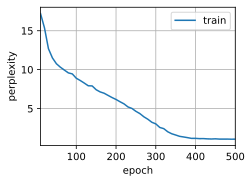

In [9]:
# 获取词汇表大小、隐藏层单元数和设备
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()

# 设置训练的轮数和学习率
num_epochs, lr = 500, 1

# 创建 RNN 模型实例
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
# RNN的实现
# net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
#                       init_rnn_state, rnn)
# 模型只将RNN换成GRU


# 创建 RNN 模型实例：

# model = d2l.RNNModelScratch(...):
# 创建一个 RNN 模型实例 model，使用以下参数：
# len(vocab): 传入词汇表大小。
# num_hiddens: 传入隐藏层单元数量。
# device: 传入设备（CPU 或 GPU）。
# get_params: 获取参数的函数。
# init_gru_state: 初始化 GRU 隐状态的函数。
# gru: 前向传播的 GRU 函数。

# 开始训练模型
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

RNN（循环神经网络）和 GRU（门控递归单元）都是用于处理序列数据的神经网络架构

RNN：传统的 RNN 结构相对简单。它使用一个隐状态来捕获输入序列中的依赖关系。每个时间步的输出和下一个时间步的隐状态都是基于当前输入和前一个时间步的隐状态来计算的。
GRU：GRU 是一种特殊类型的 RNN，其结构更加复杂。GRU 引入了门控机制来控制信息的流动，包括更新门和重置门。这使得 GRU 能够更灵活地捕获长距离依赖关系。



perplexity 1.0, 126730.7 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
travelleryou can show black is white by argument said filby


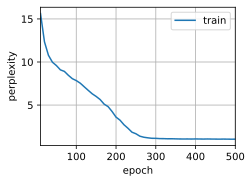

In [10]:
# GRU的简易实现

# 设置输入特征的数量为词汇表大小
num_inputs = vocab_size  

# 创建一个 GRU 层，输入特征大小为 num_inputs，隐藏层大小为 num_hiddens
gru_layer = nn.GRU(num_inputs, num_hiddens)

# 创建 RNN 模型实例，传入 GRU 层和词汇表的大小
model = d2l.RNNModel(gru_layer, len(vocab))

# 将模型移动到指定的设备（GPU 或 CPU）
model = model.to(device)

# 开始训练模型，传入训练数据迭代器、词汇表、学习率、训练轮数和设备
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)